In [1]:
# pad your sequences

from torch.nn.utils.rnn import pad_sequence
from pytorch_lightning.callbacks import LearningRateMonitor
import torch
import numpy as np
from PIL import Image
import os
from collections import defaultdict
import json
import joblib
from torch.utils.data import Dataset,DataLoader,random_split
from itertools import repeat
import pandas as pd
import math
import torch.nn as nn
import torch.nn.functional as F
from numpy import linalg as LA
from argparse import Namespace
from numpy import genfromtxt
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
import wandb
import logging
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint,LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import clip


import wandb
import logging
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import os

logger = logging.getLogger(__name__)
wandb_logger = lambda dir, version: WandbLogger(
    name="wandb", save_dir=dir, version=version
)
csvlogger = lambda dir, version: CSVLogger(dir, name="csvlogs", version=version)
tblogger = lambda dir, version: TensorBoardLogger(dir, name="tblogs", version=version)

def get_loggers(dir,version,lis=["csv"]):
    lgrs = []
    if "wandb" in lis:
        lgrs.append(wandb_logger(dir, version))
    if "csv" in lis:
        lgrs.append(csvlogger(dir, version))
    if "tb" in lis:
        lgrs.append(tblogger(dir, version))
    return lgrs







def get_vid_ids(split='training',\
    annotns_file='/common/home/vk405/Projects/Crossmdl/Data/YouCookII/annotations/youcookii_annotations_trainval.json'):
    # Returns vid_ids corresponding to the split: 'training'/'validation'
    
    vid_lis = []
    with open(annotns_file) as json_file:
        annotns = json.load(json_file)['database']
        for key in annotns:
            if annotns[key]['subset'] == split:
                vid_lis.append(key)
    return vid_lis


def get_split_files(split='training',\
    annotns_file='/common/home/vk405/Projects/Crossmdl/Data/YouCookII/annotations/youcookii_annotations_trainval.json',\
        data_dir = '/common/users/vk405/Youcook/'):
    total_ids = get_vid_ids(split,annotns_file)
    downloaded_ids = set([dir for dir in os.listdir(data_dir) if 'joblib' not in dir])
    vid_locs = []
    sents = {}
    segs = {}
    incomplete = []
    for id in total_ids:
        if id in downloaded_ids:
            vid_loc = data_dir+id + '/'
            if len(os.listdir(vid_loc))>=495:
                vid_locs.append(vid_loc)
                seg = joblib.load(data_dir+f'{id}global_segs.joblib')
                sent = joblib.load(data_dir+f'{id}global_sents.joblib')
                try:
                    sents[id] = sent[id]
                    segs[id] = seg[id]
                except:
                    print(f"{id} is no corresponding global sent/seg")
            else:
                #print(f"{id} has only imgs {len(os.listdir(vid_loc))}")
                incomplete.append(id)
    return vid_locs,segs,sents,incomplete 



/common/home/vk405/miniconda3/envs/Crossmdl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

import pathlib

FEAT_DIR = pathlib.Path('/common/users/vk405/CLIP_FEAT')
RAWFRAME_DIR = pathlib.Path('/common/users/vk405/Youcook/')
tokens =  {'O':0,'B':1,'I':2}


# modified with #nclasses
class Dset(Dataset):
    def __init__(self,data_dir,feat_dir,split='training'):
        self.data_dir = data_dir
        self.feat_dir = feat_dir
        self.split = split
        self.vid_ids,self.sents = self.get_ids()
        self.labels = self.getlabels()
        self.sanitycheck()
        #self.data = self.getdata()
        
    def segs_class(self,segs):
        out = np.zeros(500)
        for segid,seg in enumerate(segs):
            st,end = seg
            out[st:end+1] = segid+1
        return out    


    def sanitycheck(self):
        mis = []
        #import pdb;pdb.set_trace()
        for key in self.labels.keys():
            txt_loc = self.feat_dir/self.split/f'txt_{key}.joblib'
            txt = joblib.load(txt_loc)
            if len(self.labels[key]) == len(self.sents[key]) == len(txt):
                pass
            else:
                print(key)
                mis.append(key)
        print(f"segs are not matching:{mis}")
        for key in mis:
            self.vid_ids.remove(key)
        self.sents = None

        
        

    def __len__(self):
        return len(self.vid_ids)

    def __getitem__(self,idx):
        return self.load(self.vid_ids[idx])

    def load(self,vid_id):
        vid_frames_loc = self.feat_dir/self.split/f'vid_{vid_id}.joblib'
        txt_loc = self.feat_dir/self.split/f'txt_{vid_id}.joblib'
        vid = joblib.load(vid_frames_loc)
        try:
            txt = joblib.load(txt_loc)
        except:
            import pdb;pdb.set_trace()
        segs = self.labels[vid_id]
        labels = self.segs_class(segs)
        return vid,txt,labels

    def getlabels(self):
        label_dict = {}
        for vidid in self.vid_ids:
            vidloc = self.data_dir/vidid
            segs = self.extract_seg(vidloc)
            label_dict[vidid] = segs
        return label_dict
    
    def extract_seg(self,vid_loc):
        imgs = sorted(os.listdir(vid_loc),key=lambda x: int(x.split('_')[0]))
        segs = defaultdict(list)
        for img in imgs:
            ind,rem = int(img.split('_')[0]),img.split('_')[-1]
            
            if 'n.' not in rem:
                #print(ind,rem)
                seg_id = int(rem.split('.')[0])
                segs[seg_id].append(ind)
                #print(seg_id,ind)
        final_segs = []
        #import pdb;pdb.set_trace()
        segids = sorted(segs.keys())
        for segid in segids:
            final_segs.append((min(segs[segid]),max(segs[segid])))
        return final_segs
        
    def get_ids(self):
        annotns_file='/common/home/vk405/Projects/Crossmdl/Data/YouCookII/annotations/youcookii_annotations_trainval.json'
        data_dir = '/common/users/vk405/Youcook/'
        vid_locs,_,sents,_ = get_split_files(self.split,annotns_file,data_dir)
        ids = [ele.split('/')[-2] for ele in vid_locs]
        files = set(os.listdir(self.feat_dir/self.split))
        finids = []
        missing = []
        for id in ids:
            if f'vid_{id}.joblib' in files:
                finids.append(id)
            else:missing.append(id)
        print(f"missing:{missing}")
        return finids,sents



In [3]:
# CROSS-ATTN LAYER
#model utils

#!pip install transformers

def init_parameters_xavier_uniform(model):
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

def scaled_dot(query, key, mask_key=None):  
    score = torch.matmul(query, key.transpose(-2, -1))
    score /= math.sqrt(query.size(-1))
    if mask_key is not None:
        score = score.masked_fill(mask_key, -1e18)  # Represents negative infinity
    return score      
            
def attend(query, key, value, mask_key=None, dropout=None):
    # TODO: Implement
    # Use scaled_dot, be sure to mask key
    #smax = nn.Softmax(-1)
    #import pdb;pdb.set_trace()
    score = scaled_dot(query,key,mask_key)  
    attention = F.softmax(score,dim=-1)
    if dropout is not None:#do = nn.Dropout(dropout)
        attention = dropout(attention)
    answer = torch.matmul(attention,value) 
    # Convexly combine value embeddings using attention, this should be just a matrix-matrix multiplication.
    return answer, attention



def split_heads(batch, num_heads):  
    (batch_size, length, dim) = batch.size()  # These are the expected batch dimensions.
    assert dim % num_heads == 0  # Assert that dimension is divisible by the number of heads.
    dim_head = dim // num_heads

    # No new memory allocation
    splitted = batch.view(batch_size, -1, num_heads, dim_head).transpose(1, 2)  
    return splitted  # (batch_size, num_heads, length, dim_head), note that now the last two dimensions are compatible with our attention functions. 




def merge_heads(batch):  
    (batch_size, num_heads, length, dim_head) = batch.size()  # These are the expected batch dimensions.

    # New memory allocation (reshape), can't avoid.
    merged = batch.transpose(1, 2).reshape(batch_size, -1, num_heads * dim_head)
    return merged  # (batch_size, length, dim)


class MultiHeadAttention(nn.Module):
    def __init__(self, dim, num_heads, dropout_rate=0.1):
        super().__init__()
        assert dim % num_heads == 0

        self.linear_query = nn.Linear(dim, dim)
        self.linear_key = nn.Linear(dim, dim)
        self.linear_value = nn.Linear(dim, dim)
        self.linear_final = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout_rate)

        self.num_heads = num_heads

    def forward(self, query, key, value, mask_key=None, layer_cache=None,
              memory_attention=False):
        """
        INPUT
          query: (batch_size, length_query, dim)
          key: (batch_size, length_key, dim)
          value: (batch_size, length_key, dim_value)
          mask_key: (*, 1, length_key) if queries share the same mask, else
                    (*, length_query, length_key)
          layer_cache: if not None, stepwise decoding (cache of key/value)
          memory_attention: doing memory attention in stepwise decoding?
        OUTPUT
          answer: (batch_size, length_query, dim_value)
          attention: (batch_size, num_heads, length_query, length_key) else
        """
        batch_size = query.size(0)

        query = self.linear_query(query)
        query = split_heads(query, self.num_heads)  # (batch_size, num_heads, -1, dim_head)

        def process_key_value(key, value):  # Only called when necessary.
            key = self.linear_key(key)
            key = split_heads(key, self.num_heads)
            value = self.linear_value(value)
            value = split_heads(value, self.num_heads)
            return key, value

        #import pdb;pdb.set_trace()
        if layer_cache is None:
            key, value = process_key_value(key, value)
        else:
            assert query.size(2) == 1  # Stepwise decoding
            
            if memory_attention:
                if layer_cache['memory_key'] is None:  # One-time calculation
                    key, value = process_key_value(key, value)
                    # (batch_size, num_heads, length_memory, dim)
                    layer_cache['memory_key'] = key
                    layer_cache['memory_value'] = value

                key = layer_cache['memory_key']
                value = layer_cache['memory_value']

            else:  # Self-attention during decoding
                key, value = process_key_value(key, value)
                assert key.size(2) == 1 and value.size(2) == 1
                
                # Append to previous.
                if layer_cache['self_key'] is not None:
                    key = torch.cat((layer_cache['self_key'], key), dim=2)
                    value = torch.cat((layer_cache['self_value'], value), dim=2)
                    
                 # (batch_size, num_heads, length_decoded, dim)
                layer_cache['self_key'] = key  # Recache.
                layer_cache['self_value'] = value
        # Because we've splitted embeddings into heads, we must also split the mask. 
        # And because each query uses the same mask for all heads (we don't use different masking for different heads), 
        # we can specify length 1 for the head dimension.
        if mask_key is not None:  
            mask_key = mask_key.unsqueeze(1)  # (batch_size, 1, -1, length_key)

        answer, attention = attend(query, key, value, mask_key, self.dropout)

        answer = merge_heads(answer)  # (batch_size, length_key, dim)
        answer = self.linear_final(answer)

        return answer, attention

class PositionwiseFeedForward(nn.Module):
    def __init__(self, dim, dim_hidden, drop_rate=0.1):
        super().__init__()
        self.w1 = nn.Linear(dim, dim_hidden)
        self.w2 = nn.Linear(dim_hidden, dim)
        self.layer_norm = nn.LayerNorm(dim, eps=1e-6)
        self.drop1 = nn.Dropout(drop_rate)
        self.relu = nn.ReLU()
        self.drop2 = nn.Dropout(drop_rate)
    def forward(self, x):
        inter = self.drop1(self.relu(self.w1(self.layer_norm(x))))
        output = self.drop2(self.w2(inter))
        return output + x




class SinusoidalPositioner(nn.Module):
    def __init__(self, dim, drop_rate=0.1, length_max=5000):
        super().__init__()
        frequency = torch.exp(torch.arange(0, dim, 2) * -(math.log(10000.) / dim))  # Using different frequency for each dim
        positions = torch.arange(0, length_max).unsqueeze(1)
        wave = torch.zeros(length_max, dim)
        wave[:, 0::2] = torch.sin(frequency * positions)
        wave[:, 1::2] = torch.cos(frequency * positions)
        self.register_buffer('wave', wave.unsqueeze(0))  # (1, length_max, dim)
        self.dropout = nn.Dropout(drop_rate)
        self.dim = dim
        self.length_max = length_max
    def forward(self, x, step=-1):
        assert x.size(-2) <= self.length_max

        if step < 0:  # Take the corresponding leftmost embeddings.
            position_encoding = self.wave[:, :x.size(-2), :]
        else:  # Take the embedding at the step.
            position_encoding = self.wave[:, step, :]

        x = x * math.sqrt(self.dim)
        return self.dropout(x + position_encoding)




class TransformerEncoderLayer(nn.Module):

  def __init__(self, dim, num_heads, dim_hidden, drop_rate):
    super().__init__()
    self.layer_norm = nn.LayerNorm(dim, eps=1e-6)
    self.self_attention = MultiHeadAttention(dim, num_heads, drop_rate)
    self.drop = nn.Dropout(drop_rate)
    self.feedforward = PositionwiseFeedForward(dim, dim_hidden, drop_rate)

  def forward(self, source, mask_source=None):
    # TODO: Implement
    #print(source.shape)
    normed = self.layer_norm(source)  
    # Apply layer norm on source

    attended, attention = self.self_attention(normed,normed,normed,mask_source)
    #None, None  # Apply self-attention on normed (be sure to use mask_source).
    attended = self.drop(attended) + source  
    # Re-write attended by applying dropout and adding a residual connection to source.
    return self.feedforward(attended), attention




class CrossAttentionLayer(nn.Module):
    def __init__(self,dim,num_heads,dim_hidden,drop_rate):
        super().__init__()
        self.layer_norm = nn.LayerNorm(dim, eps=1e-6)
        self.context_attention = MultiHeadAttention(dim, num_heads, drop_rate)
        self.drop = nn.Dropout(drop_rate)
        self.feedforward = PositionwiseFeedForward(dim, dim_hidden, drop_rate)
        
    def forward(self,target,memory,layer_cache=None):
        
        cross_attn_target = self.layer_norm(target)
        attended, attention = self.context_attention(cross_attn_target,memory,memory,layer_cache=layer_cache,memory_attention=True)
        
        attended = target + self.drop(attended)
        
        return self.feedforward(attended),attention



layer_cache = {'memory_key': None, 'memory_value': None, 'self_key': None, 'self_value': None}


In [4]:
class LstmAttn(nn.Module):
    def __init__(self,lstm_lyrs,lstm_hdim,bidirectional,input_dim,nheads,attn_hdim,attn_dropout,tgt_dim):
        self.lstm_lyrs,self.lstm_hdim,self.bidirectional,self.input_dim,self.nheads,self.attn_hdim,self.attn_dropout,self.tgt_dim = \
            lstm_lyrs,lstm_hdim,bidirectional,input_dim,nheads,attn_hdim,attn_dropout,tgt_dim
        super().__init__()
        if bidirectional:
            #as lstm concates both directions
            lstm_hdim = lstm_hdim//2
        self.lstm = nn.LSTM(input_dim,lstm_hdim,\
        lstm_lyrs,bidirectional=bidirectional,batch_first=True)
        self.crossattn = CrossAttentionLayer(self.lstm_hdim,nheads,attn_hdim,attn_dropout)
        self.txt_enc = nn.Linear(input_dim,self.lstm_hdim)
        self.attn_weights = None
        self.act = nn.ReLU()
        self.tgt_enc = nn.Linear(self.lstm_hdim,tgt_dim)

    def forward(self,vid,txt):
        #import pdb;pdb.set_trace()
        hiddens, (final_h, final_c) = self.lstm(vid)
        txt_inp = self.act(self.txt_enc(txt))
        out_emb,self.attn_weights = self.crossattn(hiddens,txt_inp)
        tgt_emb = self.tgt_enc(out_emb)
        return tgt_emb
        

        

In [5]:
from typing import List, Optional

import torch
import torch.nn as nn


class CRF(nn.Module):
    """Conditional random field.
    This module implements a conditional random field [LMP01]_. The forward computation
    of this class computes the log likelihood of the given sequence of tags and
    emission score tensor. This class also has `~CRF.decode` method which finds
    the best tag sequence given an emission score tensor using `Viterbi algorithm`_.
    Args:
        num_tags: Number of tags.
        batch_first: Whether the first dimension corresponds to the size of a minibatch.
    Attributes:
        start_transitions (`~torch.nn.Parameter`): Start transition score tensor of size
            ``(num_tags,)``.
        end_transitions (`~torch.nn.Parameter`): End transition score tensor of size
            ``(num_tags,)``.
        transitions (`~torch.nn.Parameter`): Transition score tensor of size
            ``(num_tags, num_tags)``.
    .. [LMP01] Lafferty, J., McCallum, A., Pereira, F. (2001).
       "Conditional random fields: Probabilistic models for segmenting and
       labeling sequence data". *Proc. 18th International Conf. on Machine
       Learning*. Morgan Kaufmann. pp. 282–289.
    .. _Viterbi algorithm: https://en.wikipedia.org/wiki/Viterbi_algorithm
    """

    def __init__(self, num_tags: int, batch_first: bool = False) -> None:
        if num_tags <= 0:
            raise ValueError(f'invalid number of tags: {num_tags}')
        super().__init__()
        self.num_tags = num_tags
        self.batch_first = batch_first
        self.start_transitions = nn.Parameter(torch.empty(num_tags))
        self.end_transitions = nn.Parameter(torch.empty(num_tags))
        self.transitions = nn.Parameter(torch.empty(num_tags, num_tags))

        self.reset_parameters()

    def reset_parameters(self) -> None:
        """Initialize the transition parameters.
        The parameters will be initialized randomly from a uniform distribution
        between -0.1 and 0.1.
        """
        nn.init.uniform_(self.start_transitions, -0.1, 0.1)
        nn.init.uniform_(self.end_transitions, -0.1, 0.1)
        nn.init.uniform_(self.transitions, -0.1, 0.1)
        

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(num_tags={self.num_tags})'

    def forward(
            self,
            emissions: torch.Tensor,
            tags: torch.LongTensor,
            mask: Optional[torch.ByteTensor] = None,
            reduction: str = 'sum',
    ) -> torch.Tensor:
        """Compute the conditional log likelihood of a sequence of tags given emission scores.
        Args:
            emissions (`~torch.Tensor`): Emission score tensor of size
                ``(seq_length, batch_size, num_tags)`` if ``batch_first`` is ``False``,
                ``(batch_size, seq_length, num_tags)`` otherwise.
            tags (`~torch.LongTensor`): Sequence of tags tensor of size
                ``(seq_length, batch_size)`` if ``batch_first`` is ``False``,
                ``(batch_size, seq_length)`` otherwise.
            mask (`~torch.ByteTensor`): Mask tensor of size ``(seq_length, batch_size)``
                if ``batch_first`` is ``False``, ``(batch_size, seq_length)`` otherwise.
            reduction: Specifies  the reduction to apply to the output:
                ``none|sum|mean|token_mean``. ``none``: no reduction will be applied.
                ``sum``: the output will be summed over batches. ``mean``: the output will be
                averaged over batches. ``token_mean``: the output will be averaged over tokens.
        Returns:
            `~torch.Tensor`: The log likelihood. This will have size ``(batch_size,)`` if
            reduction is ``none``, ``()`` otherwise.
        """
        self._validate(emissions, tags=tags, mask=mask)
        if reduction not in ('none', 'sum', 'mean', 'token_mean'):
            raise ValueError(f'invalid reduction: {reduction}')
        if mask is None:
            mask = torch.ones_like(tags, dtype=torch.uint8)

        if self.batch_first:
            emissions = emissions.transpose(0, 1)
            tags = tags.transpose(0, 1)
            mask = mask.transpose(0, 1)

        # shape: (batch_size,)
        numerator = self._compute_score(emissions, tags, mask)
        # shape: (batch_size,)
        denominator = self._compute_normalizer(emissions, mask)
        # shape: (batch_size,)
        llh = numerator - denominator

        if reduction == 'none':
            return llh
        if reduction == 'sum':
            return llh.sum()
        if reduction == 'mean':
            return llh.mean()
        assert reduction == 'token_mean'
        return llh.sum() / mask.type_as(emissions).sum()

    def decode(self, emissions: torch.Tensor,
               mask: Optional[torch.ByteTensor] = None) -> List[List[int]]:
        """Find the most likely tag sequence using Viterbi algorithm.
        Args:
            emissions (`~torch.Tensor`): Emission score tensor of size
                ``(seq_length, batch_size, num_tags)`` if ``batch_first`` is ``False``,
                ``(batch_size, seq_length, num_tags)`` otherwise.
            mask (`~torch.ByteTensor`): Mask tensor of size ``(seq_length, batch_size)``
                if ``batch_first`` is ``False``, ``(batch_size, seq_length)`` otherwise.
        Returns:
            List of list containing the best tag sequence for each batch.
        """
        self._validate(emissions, mask=mask)
        if mask is None:
            mask = emissions.new_ones(emissions.shape[:2], dtype=torch.uint8)

        if self.batch_first:
            emissions = emissions.transpose(0, 1)
            mask = mask.transpose(0, 1)

        return self._viterbi_decode(emissions, mask)

    def _validate(
            self,
            emissions: torch.Tensor,
            tags: Optional[torch.LongTensor] = None,
            mask: Optional[torch.ByteTensor] = None) -> None:
        if emissions.dim() != 3:
            raise ValueError(f'emissions must have dimension of 3, got {emissions.dim()}')
        if emissions.size(2) != self.num_tags:
            raise ValueError(
                f'expected last dimension of emissions is {self.num_tags}, '
                f'got {emissions.size(2)}')

        if tags is not None:
            if emissions.shape[:2] != tags.shape:
                raise ValueError(
                    'the first two dimensions of emissions and tags must match, '
                    f'got {tuple(emissions.shape[:2])} and {tuple(tags.shape)}')

        if mask is not None:
            if emissions.shape[:2] != mask.shape:
                raise ValueError(
                    'the first two dimensions of emissions and mask must match, '
                    f'got {tuple(emissions.shape[:2])} and {tuple(mask.shape)}')
            no_empty_seq = not self.batch_first and mask[0].all()
            no_empty_seq_bf = self.batch_first and mask[:, 0].all()
            if not no_empty_seq and not no_empty_seq_bf:
                raise ValueError('mask of the first timestep must all be on')

    def _compute_score(
            self, emissions: torch.Tensor, tags: torch.LongTensor,
            mask: torch.ByteTensor) -> torch.Tensor:
        # emissions: (seq_length, batch_size, num_tags)
        # tags: (seq_length, batch_size)
        # mask: (seq_length, batch_size)
        assert emissions.dim() == 3 and tags.dim() == 2
        assert emissions.shape[:2] == tags.shape
        assert emissions.size(2) == self.num_tags
        assert mask.shape == tags.shape
        assert mask[0].all()

        seq_length, batch_size = tags.shape
        mask = mask.type_as(emissions)

        # Start transition score and first emission
        # shape: (batch_size,)
        score = self.start_transitions[tags[0]]
        score += emissions[0, torch.arange(batch_size), tags[0]]

        for i in range(1, seq_length):
            # Transition score to next tag, only added if next timestep is valid (mask == 1)
            # shape: (batch_size,)
            score += self.transitions[tags[i - 1], tags[i]] * mask[i]

            # Emission score for next tag, only added if next timestep is valid (mask == 1)
            # shape: (batch_size,)
            score += emissions[i, torch.arange(batch_size), tags[i]] * mask[i]

        # End transition score
        # shape: (batch_size,)
        seq_ends = mask.long().sum(dim=0) - 1
        # shape: (batch_size,)
        last_tags = tags[seq_ends, torch.arange(batch_size)]
        # shape: (batch_size,)
        score += self.end_transitions[last_tags]

        return score

    def _compute_normalizer(
            self, emissions: torch.Tensor, mask: torch.ByteTensor) -> torch.Tensor:
        # emissions: (seq_length, batch_size, num_tags)
        # mask: (seq_length, batch_size)
        assert emissions.dim() == 3 and mask.dim() == 2
        assert emissions.shape[:2] == mask.shape
        assert emissions.size(2) == self.num_tags
        assert mask[0].all()

        seq_length = emissions.size(0)

        # Start transition score and first emission; score has size of
        # (batch_size, num_tags) where for each batch, the j-th column stores
        # the score that the first timestep has tag j
        # shape: (batch_size, num_tags)
        score = self.start_transitions + emissions[0]

        for i in range(1, seq_length):
            # Broadcast score for every possible next tag
            # shape: (batch_size, num_tags, 1)
            broadcast_score = score.unsqueeze(2)

            # Broadcast emission score for every possible current tag
            # shape: (batch_size, 1, num_tags)
            broadcast_emissions = emissions[i].unsqueeze(1)

            # Compute the score tensor of size (batch_size, num_tags, num_tags) where
            # for each sample, entry at row i and column j stores the sum of scores of all
            # possible tag sequences so far that end with transitioning from tag i to tag j
            # and emitting
            # shape: (batch_size, num_tags, num_tags)
            next_score = broadcast_score + self.transitions + broadcast_emissions

            # Sum over all possible current tags, but we're in score space, so a sum
            # becomes a log-sum-exp: for each sample, entry i stores the sum of scores of
            # all possible tag sequences so far, that end in tag i
            # shape: (batch_size, num_tags)
            next_score = torch.logsumexp(next_score, dim=1)

            # Set score to the next score if this timestep is valid (mask == 1)
            # shape: (batch_size, num_tags)
            score = torch.where(mask[i].unsqueeze(1), next_score, score)

        # End transition score
        # shape: (batch_size, num_tags)
        score += self.end_transitions

        # Sum (log-sum-exp) over all possible tags
        # shape: (batch_size,)
        return torch.logsumexp(score, dim=1)

    def _viterbi_decode(self, emissions: torch.FloatTensor,
                        mask: torch.ByteTensor) -> List[List[int]]:
        # emissions: (seq_length, batch_size, num_tags)
        # mask: (seq_length, batch_size)
        assert emissions.dim() == 3 and mask.dim() == 2
        assert emissions.shape[:2] == mask.shape
        assert emissions.size(2) == self.num_tags
        assert mask[0].all()

        seq_length, batch_size = mask.shape

        # Start transition and first emission
        # shape: (batch_size, num_tags)
        score = self.start_transitions + emissions[0]
        history = []

        # score is a tensor of size (batch_size, num_tags) where for every batch,
        # value at column j stores the score of the best tag sequence so far that ends
        # with tag j
        # history saves where the best tags candidate transitioned from; this is used
        # when we trace back the best tag sequence

        # Viterbi algorithm recursive case: we compute the score of the best tag sequence
        # for every possible next tag
        for i in range(1, seq_length):
            # Broadcast viterbi score for every possible next tag
            # shape: (batch_size, num_tags, 1)
            broadcast_score = score.unsqueeze(2)

            # Broadcast emission score for every possible current tag
            # shape: (batch_size, 1, num_tags)
            broadcast_emission = emissions[i].unsqueeze(1)

            # Compute the score tensor of size (batch_size, num_tags, num_tags) where
            # for each sample, entry at row i and column j stores the score of the best
            # tag sequence so far that ends with transitioning from tag i to tag j and emitting
            # shape: (batch_size, num_tags, num_tags)
            next_score = broadcast_score + self.transitions + broadcast_emission

            # Find the maximum score over all possible current tag
            # shape: (batch_size, num_tags)
            next_score, indices = next_score.max(dim=1)

            # Set score to the next score if this timestep is valid (mask == 1)
            # and save the index that produces the next score
            # shape: (batch_size, num_tags)
            score = torch.where(mask[i].unsqueeze(1), next_score, score)
            history.append(indices)

        # End transition score
        # shape: (batch_size, num_tags)
        score += self.end_transitions

        # Now, compute the best path for each sample

        # shape: (batch_size,)
        seq_ends = mask.long().sum(dim=0) - 1
        best_tags_list = []

        for idx in range(batch_size):
            # Find the tag which maximizes the score at the last timestep; this is our best tag
            # for the last timestep
            _, best_last_tag = score[idx].max(dim=0)
            best_tags = [best_last_tag.item()]

            # We trace back where the best last tag comes from, append that to our best tag
            # sequence, and trace it back again, and so on
            for hist in reversed(history[:seq_ends[idx]]):
                best_last_tag = hist[idx][best_tags[-1]]
                best_tags.append(best_last_tag.item())

            # Reverse the order because we start from the last timestep
            best_tags.reverse()
            best_tags_list.append(best_tags)

        return best_tags_list

In [9]:
class ClipCRF(pl.LightningModule):
    def __init__(self,hparams):
        super().__init__()
        self.save_hyperparameters(hparams)
        self.emission_model = LstmAttn(**self.hparams.emission_model)
        self.crf = CRF(self.hparams.emission_model['tgt_dim'])

    def forward(self,vid,txt):
        tgt_emb = self.emission_model(vid.float(),txt.float())
        batch_size,seq_length,num_tags = tgt_emb.shape
        emissions = torch.reshape(tgt_emb,(seq_length, batch_size, num_tags))
        return self.crf.decode(emissions)

    def training_step(self,batch,batch_idx):
        vid,txt,labels = batch
        batch_size,seq_length = labels.shape
        labels = torch.reshape(torch.tensor(labels,dtype=torch.long),(seq_length,batch_size))
        
        tgt_emb = self.emission_model(vid.float(),txt.float())
        batch_size,seq_length,num_tags = tgt_emb.shape
        emissions = torch.reshape(tgt_emb,(seq_length, batch_size, num_tags))
        loglike = self.crf(emissions,labels)
        loss = -1*loglike
        self.log("train_loglikelihood",loglike,on_step=True)
        self.log("train_loss",loss,on_step=True)
        return loss

    def validation_step(self,batch,batch_idx):
        vid,txt,labels = batch
        batch_size,seq_length = labels.shape
        labels = torch.reshape(torch.tensor(labels,dtype=torch.long),(seq_length,batch_size))
        
        tgt_emb = self.emission_model(vid.float(),txt.float())
        batch_size,seq_length,num_tags = tgt_emb.shape
        emissions = torch.reshape(tgt_emb,(seq_length, batch_size, num_tags))
        loglike = self.crf(emissions,labels)
        loss = -1*loglike
        self.log("val_loss",loss,on_step=False,on_epoch=True)
        return loss

    def configure_optimizers(self):
        num_warmup_steps = self.hparams.num_warmup_steps
        lr_dim = self.hparams.lr_dim
        
        optimizer = torch.optim.Adam(self.parameters(),lr=self.hparams.lr,betas=(0.9, 0.98), eps=1e-9)
        #scheduler = ScheduledOptim(optimizer,1,lr_dim,num_warmup_steps)
        return optimizer
    

In [10]:
from torch.utils.data import ConcatDataset
def get_testdset(cfg):
    #returns test and validation set joined
    valset = Dset(cfg.RAWFRAME_DIR,cfg.FEAT_DIR)
    tset = Dset(cfg.RAWFRAME_DIR,cfg.FEAT_DIR,'validation')
    totset = ConcatDataset([valset,tset])
    return totset
    
    

In [13]:
cfg = Namespace(
version = 'clip_crf_trn_ncls',
id = 0,
FEAT_DIR = FEAT_DIR,
RAWFRAME_DIR = RAWFRAME_DIR,
artifacts_loc = "/common/home/vk405/Projects/Crossmdl/nbs/",
data_dir = "/common/home/vk405/Projects/Crossmdl/Data/YouCookII/",
trn_split = 0.8,
mode = 'train',
split = 'training',
loggers = ["csv"],
seed = 0,
emission_model = {'bidirectional':True,'input_dim':512,'nheads':1,'lstm_lyrs':1,\
'lstm_hdim':128,'attn_hdim':64,\
'attn_dropout':0.0,
'tgt_dim': 17
},
cbs = ["checkpoint"],
trainer = {'log_every_n_steps': 1, 
'max_epochs': 60},
checkpoint = {"every_n_epochs": 1,
"monitor": "val_loss"},
early_stop = {"monitor":"val_loss","mode":"min","patience":5},
lr = 1e-4,
lr_dim = 200,
num_warmup_steps = 4000,
batch_sz = 1


)

In [8]:
#m = ClipCRF(cfg)


from pathlib import Path
def get_model(cfg):
    #takes the first stored weight
    hparams = cfg    
    PATH = Path(cfg.artifacts_loc)/'ckpts'/cfg.version
    ckpt = os.listdir(PATH)[1]
    net = ClipCRF(hparams)
    print(f"loading ckpt:{ckpt}")
    new_model = net.load_from_checkpoint(checkpoint_path=str(PATH/ckpt))
    return new_model

In [24]:
from tqdm import tqdm
def inference(model,dl):
    frame_level_acc = []
    labellis = []
    predlis = []
    model.eval()
    for batch in tqdm(dl):
        vid,text,labels = batch
        pred_labels = model(vid,text)
        ground_labels = labels.detach().cpu().numpy()[0]
        predlis.append(pred_labels)
        labellis.append(ground_labels)
        acc = np.mean(ground_labels == pred_labels)
        frame_level_acc.append(acc)
    joblib.dump(labellis,'labellis.joblib')
    joblib.dump(predlis,'predlis.joblib')
    return np.mean(frame_level_acc),labellis,predlis
        
        
    

In [12]:
#get-dataloader
d_test = get_testdset(cfg)
testl = DataLoader(d_test,batch_size=1,shuffle=False,num_workers = 5)


missing:['ukfCQQpZ0k4', 'NK2xHVWojgY', 'mixdagZ-fwI']
cwsDQ7M5OTI
uf65nfh6X2U
segs are not matching:['cwsDQ7M5OTI', 'uf65nfh6X2U']
missing:[]
95WMX64RIBc
segs are not matching:['95WMX64RIBc']


In [15]:
model = get_model(cfg)

loading ckpt:epoch=216-train_loss=91.17.ckpt


In [18]:
#studying attention weights
def study_attn():
    # returns the percentile score of ground truth segments
    i = np.random.choice(100)
    testl = DataLoader(d_test,batch_size=1,shuffle=False,num_workers = 5)
    for ind,batch in enumerate(testl):
        if ind == i:
            vid,text,labels = batch
            with torch.no_grad():
                PRED = model(vid,text)
            base_segs = extract_segs(labels.numpy())
            st,end = base_segs[0][0]
            first_seg_attn = torch.squeeze(model.emission_model.attn_weights[:,:,:,1]).numpy()
            s1 = np.mean(first_seg_attn[st:end+1])
            sz = end-st
            avgs = []
            for i in range(1000):
                st_id = np.random.randint(500-sz)
                end_id = st_id+sz
                m = np.mean(first_seg_attn[st_id:end_id])
                avgs.append(m)
            from scipy import stats
    return stats.percentileofscore(avgs,s1)




In [29]:
M = model.crf.transitions.detach().cpu().numpy()
M.shape

(17, 17)

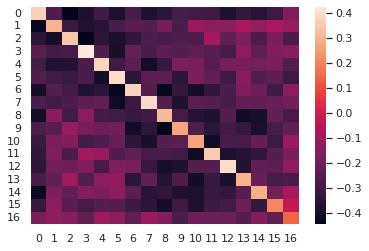

In [30]:
#visualizing transition matrix

import numpy as np; 
import seaborn as sns; sns.set_theme()
#uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(M)

In [14]:
# Visualizing attention weights

batch = next(iter(testl))
vid,text,labels = batch
with torch.no_grad():
    PRED = model(vid,text)


<ipython-input-5-be86d3c016ba>:293: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  ../aten/src/ATen/native/TensorCompare.cpp:328.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


In [18]:
model.emission_model.attn_weights.shape

torch.Size([1, 1, 500, 5])

In [22]:
base_segs = extract_segs(labels.numpy())
base_segs

[[(186, 210), (236, 262), (273, 285), (288, 299), (358, 359)]]

In [24]:
#let's see if we actually attend to these

first_seg_attn = torch.squeeze(model.emission_model.attn_weights[:,:,:,1]).numpy()
first_seg_attn

array([0.12230025, 0.11855522, 0.119487  , 0.11929157, 0.11732614,
       0.11780079, 0.11494639, 0.11377048, 0.10968129, 0.10929181,
       0.10540858, 0.10180341, 0.10655935, 0.10909887, 0.11357592,
       0.11971118, 0.11860047, 0.1195482 , 0.11875094, 0.11856016,
       0.11857875, 0.11666175, 0.11607134, 0.1165452 , 0.11865624,
       0.11851682, 0.12026682, 0.11923701, 0.11878303, 0.11687866,
       0.11823639, 0.11776974, 0.11958972, 0.11945596, 0.11965445,
       0.11937862, 0.11987484, 0.12277874, 0.12197191, 0.12158917,
       0.11518773, 0.11267312, 0.11397988, 0.11515063, 0.11629314,
       0.11619922, 0.11395086, 0.11423334, 0.11626251, 0.11654215,
       0.11597037, 0.11653413, 0.11827859, 0.11779778, 0.11757927,
       0.1170874 , 0.11619654, 0.11651737, 0.1152657 , 0.11407791,
       0.11395665, 0.11380307, 0.11554276, 0.11762325, 0.11890599,
       0.11779173, 0.11665255, 0.11543538, 0.11453485, 0.11363327,
       0.11294598, 0.11286867, 0.11126503, 0.11011329, 0.11159

In [40]:
s1 = np.mean(first_seg_attn[186:210])

In [31]:
np.mean(first_seg_attn)

(0.09199969, 0.09404079)

In [35]:
sz = 210-186
avgs = []
for i in range(1000):
    st_id = np.random.randint(500-sz)
    end_id = st_id+sz
    m = np.mean(first_seg_attn[st_id:end_id])
    avgs.append(m)


In [41]:
from scipy import stats
stats.percentileofscore(avgs,s1)

75.5

In [23]:
# now let's do this multiple times and average

sz = 10
attn_w = []
for i in range(sz):
    w = study_attn()
    attn_w.append(w)
np.mean(attn_w)

67.66

In [31]:
t_acc,labellis,predlis = inference(model,testl)

  7%|▋         | 105/1603 [05:20<1:16:10,  3.05s/it]


KeyboardInterrupt: 

In [46]:
import joblib
labellis = joblib.load('labellis.joblib')
predlis = joblib.load('predlis.joblib')

In [20]:
def extract_segs(labels):
    #list of lists
    labelsegs = []
    predsegs = []
    for label in labels:
        sz = len(set(label))
        label = np.array(label)
        label_s = []
        for i in range(1,sz):
            #import pdb;pdb.set_trace()
            match_ids, = np.where(label==i)
            lst_end = -1
            if label_s != []:
                for prev_seg in label_s[::-1]:
                    if prev_seg:
                        lst_end = prev_seg[-1]
        
            nxt_st, = np.where(match_ids>lst_end)
            if nxt_st.size>0:
                st_ = match_ids[nxt_st[0]]
            else:
                label_s.append(())
                continue

            ind = np.where(match_ids==st_)[0][0]
            end_ = st_
            for i in range(ind,len(match_ids)):
                if i != 0:
                    if match_ids[i-1]+1 == match_ids[i]:
                        end_ = match_ids[i]
                    else:
                        break
            label_s.append((st_,end_))
        labelsegs.append(label_s)
    return labelsegs





In [21]:
#preds: list of lists corresponding to each video. [[(23,67),(89,102)]]
import numpy as np
def stats(preds,labels,sz=500):
    accs = []
    recalls = []
    ious = []
    for pred,label in zip(preds,labels):
        # note: during inference we ensure that intervals are non-overlapping
        #pred = sorted(pred,key=lambda x: x[0])
        #label = sorted(label,key=lambda x: x[0])
        pred_sz = len(pred)
        lbl_sz = len(label)
        pred_lis = np.zeros(sz)
        label_lis = np.zeros(sz)
        for ind in range(1,lbl_sz+1):
            l_st,l_end = label[ind-1]
            label_lis[l_st:l_end+1] = ind
            if ind <= pred_sz and pred[ind-1]:
                p_st,p_end = pred[ind-1]
                pred_lis[p_st:l_end+1] = ind
            else:
                # wrong predictions
                pred_lis[l_st:l_end+1] = -1


        acc = np.mean(pred_lis == label_lis)
        accs.append(acc)
        #calc recall
        #calc iou
        inter_cnt = 0
        union_cnt = 0
        recall_match = 0.0
        recall_cnt = 0
        for p_seg,l_seg in zip(pred,label):
            ls = set(range(l_seg[0],l_seg[-1]+1))
            recall_cnt += 1
            if not p_seg: 
                union_cnt += len(ls)
                continue
            ps = set(range(p_seg[0],p_seg[-1]+1))
            inter_cnt += len(ps.intersection(ls))
            union_cnt += len(ps.union(ls))
            if l_seg[0]<=p_seg[0]<=l_seg[-1]:
                recall_match += 1
            #if ps.issubset(ls):
            #recall_score.append(len(ls.intersection(ps))/len(ls))
            # correctly assign or fall into ground truth interval
            #recall_score += 1
        ms = len(label)-len(pred)
        if ms>0:
            for i in range(ms):
                recall_cnt += 1
                #recall_score.append(0.0)
        if union_cnt:
            ious.append(inter_cnt/union_cnt)
            recalls.append(recall_match/recall_cnt)
        else:
            print(pred)
            print(label)
    return np.mean(accs),np.mean(recalls),np.mean(ious)

In [49]:
p = [ele[0] for ele in predlis]

In [50]:
l = labellis

In [51]:
p_s = extract_segs(p)

In [52]:
l_s = extract_segs(l)

Evaluate random model

In [71]:

def eval_random_model(p_s,l_s):
    rs = []
    rious = []
    for i in range(100):
        r_s = []
        g_s = []
        for i,segs in enumerate(p_s):
            rp_s = []
            rg_s = []
            #randomly select a segment
            s = sorted(np.random.choice(500,2,replace=False))
            rg_s.append(l_s[i][0])
            rp_s.append((s[0],s[-1]))

            r_s.append(rp_s)
            g_s.append(rg_s)
        _,rrecall,riou = stats(r_s,g_s)
        rs.append(rrecall)
        rious.append(riou)
    return np.mean(rs),np.mean(rious)
    

    

In [72]:
# stats for a random model
eval_random_model(p_s,l_s)

(0.1165206402695872, 0.06118370194891794)

In [29]:
acc,recall,iou = stats(p_s,l_s)

[]
[(84, 161), (163, 173), (182, 205), (299, 305), (310, 336)]
[]
[(60, 71), (88, 98), (126, 132), (138, 158), (172, 172), (215, 220), (280, 282), (357, 386), (413, 436), (480, 484)]
[]
[(214, 232), (233, 252), (253, 269), (270, 276), (277, 313), (314, 352)]
[]
[(44, 65), (85, 113), (131, 197), (198, 230), (239, 244), (253, 262), (281, 283), (293, 304), (310, 315), (345, 357), (358, 367), (386, 401), (421, 427)]
[]
[(52, 84), (93, 144), (146, 187), (197, 203), (211, 226), (229, 247), (274, 281), (283, 293), (325, 330), (349, 357), (373, 400), (424, 429)]


In [30]:
recall

0.3401451246628912

In [31]:
iou

0.5320176563920543

In [32]:
acc

0.7973007582139848